# Baseline for  classifying GRIs into Concepts: 200,300,400

> This script is used to train a multiclass classifier using Bert and some other flavors, also we provide the evaluation of each strategy. For better performance we use a TPU backend.


OBS.: Need to treat words like im- pact 

In [1]:
!pip install tokenizers
!pip install transformers

import json
import pandas as pd
import string
import re
import gc
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

# !pip install sentencepiece
# from transformers import BertTokenizer, TFBertModel
# from transformers import DistilBertTokenizer, TFDistilBertModel
# from transformers import RobertaTokenizer, TFRobertaModel
# from transformers import ElectraTokenizer, TFElectraModel
# from transformers import FunnelTokenizer, TFFunnelForTokenClassification

     |████████████████████████████████| 3.3 MB 5.4 MB/s 
     |████████████████████████████████| 2.8 MB 5.2 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 895 kB 50.9 MB/s 
     |████████████████████████████████| 636 kB 57.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.5 MB/s 


In [2]:
# Accessing local drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NLP_tese/Exp1

Mounted at /content/drive
/content/drive/MyDrive/NLP_tese/Exp1


In [3]:
import nltk
from nltk.corpus import stopwords
from functools import reduce

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))
def lower(text):
    return text.lower()
def replace_special_characters(text):
    return REPLACE_BY_SPACE_RE.sub(' ', text)
def filter_out_uncommon_symbols(text):
    return GOOD_SYMBOLS_RE.sub('', text)
def remove_stopwords(text):
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])
def strip_text(text):
    return text.strip()
def remove_GRI(text):
    regex = re.compile(r'GRI|gri', re.UNICODE)
    return re.sub(regex, '', text)
def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
def remove_numbers(text):
    regex = re.compile(r'[0-9]', re.UNICODE)
    return re.sub(regex, ' ', text)
 
PREPROCESSING_PIPELINE = [
                          remove_articles,
                          remove_GRI,
                          lower,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          strip_text,
                          remove_numbers# Remove numbers
                          ]
# Anchor method
def text_prepare(text, filter_methods=None):
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), filter_methods, text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Add a wordcloud

In [4]:
## Implementing our new creat_dataframe function 
def aggregate_cat(txt):
  txt_100 = re.sub('^1[0-9][0-9]\-[0-9]+', '100', txt.strip())
  txt_200 = re.sub('^2[0-9][0-9]\-[0-9]+', '200', txt_100)
  txt_300 = re.sub('^3[0-9][0-9]\-[0-9]+', '300', txt_200)
  txt_400 = re.sub('^4[0-9][0-9]\-[0-9]+', '400', txt_300)
  return (txt_400)

def create_dataframe(ds, maxlen=512, stride=30, split=0.9, use_token_type_ids=True):
  samples = []
  # We have our ds with the format of <Filename,GRI,Text>
  #let's start aggregating our 200,300 and 400 categories
  #print(ds.dtypes)
  ds['GRI'] = ds['GRI'].apply(lambda txt: aggregate_cat(txt))
  ds['GRI'] = pd.to_numeric(ds['GRI']).astype('int32') 
  # Let's remove the 100 category
  ds.drop(ds[ds['GRI'] == 100].index, inplace=True)
  ds = ds.reset_index(drop=True)
  ds['GRI'] = ds['GRI'].astype('int32') 
  # We clean our text data
  ds['Text'] = ds['Text'].apply(lambda txt: text_prepare(txt))
  # Initialize our classification categories
  ds['GRI_cat'] = pd.Categorical(ds['GRI'])
  #print(pd.Categorical(ds['GRI']))
  ds['GRI_cat'] = keras.utils.to_categorical(ds['GRI_cat'].cat.codes)

  ###
  for index, row in ds.iterrows():
    tmp_a = row['Text']
    tmp_gri = row['GRI']
    tmp_gri_cat = row['GRI_cat']
    tmp_filename = row['Filename']
    # Split between train and validation according to the data field in the original dataframe.
    tmp_split = "train" if index < len(ds['Text']) * split else "validation"
    # If the total length exceeds the window length, the context is split with a partial overlap governed by stride.
    samples.append({"filename": tmp_filename, "text": tmp_a, "gri": tmp_gri, "gri_cat": tmp_gri_cat, "split": tmp_split})

  return pd.DataFrame(samples)


In [5]:
max_len = 512 # Windows with which each model will be trained.

if not os.path.exists("weights"):
  os.mkdir("weights")

with open("summExp1.jsonl", "r") as f:
  ts_file = pd.read_json(f,lines=True)

df = create_dataframe(ts_file, max_len, 30, 0.9)
#df.describe()
df.head()

,filename,text,gri,gri_cat,split
0,2016_Natura_EN.jsonl,financial assistance received government,200,1.0,train
1,2016_Natura_EN.jsonl,climate change efforts aim combining economic ...,200,1.0,train
2,2016_Natura_EN.jsonl,senior managers local communities brazil ...,200,1.0,train
3,2016_Natura_EN.jsonl,communities families benefitted units ...,200,1.0,train
4,2016_Natura_EN.jsonl,founded natura institute manage apply fun...,200,1.0,train


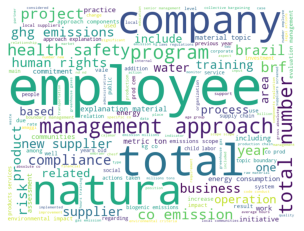

<Figure size 1152x1152 with 0 Axes>

In [6]:
## Wordloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud2 = WordCloud(width = 800, height = 600, 
            background_color ='white',  
            min_font_size = 10).generate(' '.join(df['text']))

# Generate plot
plt.axis("off")
plt.imshow(wordcloud2)
plt.figure(figsize = (16, 16), facecolor = None) 

plt.show()

In [7]:
# creating the feature matrix 
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=1000)
X = matrix.fit_transform(df['text']).toarray()

# df['matrix'] = pd.Series([X])
df['matrix'] = X.tolist()
y = df['gri']
total = len(df)
df.head()
## Preparing the training and validation set
validation_len = len(df.where(df["split"] == "validation").dropna())
print(validation_len)
print("Total: {}, train: {}, validation: {}, ratio: {}".format(total, total - validation_len, validation_len, (total - validation_len) / total))
train_df = df.where(df["split"] == "train").dropna().drop("split", axis=1).sample(frac=1).reset_index()
val_df = df.where(df["split"] == "validation").dropna().drop("split", axis=1).sample(frac=1).reset_index()
train_df.head()

78
Total: 788, train: 710, validation: 78, ratio: 0.9010152284263959


,index,filename,text,gri,gri_cat,matrix
0,408,2017_Vale_EN.jsonl,results added valuevales robust performance ...,200.0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,512,2017_Votorantim_EN.jsonl,vocs number furnaces reported total e...,300.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,519,2017_Votorantim_EN.jsonl,indirect co emissions energy indirect co e...,300.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,279,2017_Embraer_EN.jsonl,energy water embraer consumed mwh...,300.0,0.0,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4,380,2017_Natura_EN.jsonl,minimum notice period regarding operational ch...,400.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
# Naive Bayes 
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(train_df['matrix'].tolist(), train_df['gri'].tolist())

# predict class
y_pred = classifier.predict(val_df['matrix'].tolist())

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay, f1_score
cm = confusion_matrix(val_df['gri'], y_pred)
cr = classification_report(val_df['gri'], y_pred)

accuracy = accuracy_score(val_df['gri'], y_pred)
print(cr)

print('------- Accuracy -----------')

print(accuracy)

print('------- F1-Score -----------')

f1 = f1_score(val_df['gri'], y_pred, average='macro')
print(f1)

              precision    recall  f1-score   support

       200.0       0.17      0.45      0.25        11
       300.0       0.71      0.67      0.69        18
       400.0       0.72      0.47      0.57        49

    accuracy                           0.51        78
   macro avg       0.53      0.53      0.50        78
weighted avg       0.64      0.51      0.55        78

------- Accuracy -----------
0.5128205128205128
------- F1-Score -----------
0.5012051734273957


In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(val_df['gri'], y_pred)

import seaborn as sns
sns.heatmap(confusion , annot=True , xticklabels=['Negative' , 'Positive'] , yticklabels=['Negative' , 'Positive'])
plt.ylabel("Label")
plt.xlabel("Predicted")
plt.show()


Try one hot encoding to the result